## Data Preprocessing, Feature Extraction using a Pre-trained CNN and Classical Machine Learning Model Comparison for Syngenta Crop Disease Classification.



In [1]:
#1. ENVIRONMENT SETUP & IMPORTS

In [2]:
import sys
from pathlib import Path
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json # For loading class indices
import joblib # For saving baseline model


In [3]:
# Scikit-learn for ML models and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [4]:
# TensorFlow/Keras for image preprocessing and feature extraction
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [5]:
# Add project root to sys.path to import src modules

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


In [6]:
from src import config # Import configuration settings

In [7]:
# Set random seeds for reproducibility
np.random.seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)
tf.random.set_seed(config.RANDOM_SEED)


In [8]:
# Validate configuration
try:
    config.validate_config()
    config.get_config_summary()
    print("Environment and configuration loaded.")
except Exception as e:
    print(f"Error validating configuration: {e}")
    sys.exit(1)


CONFIGURATION SUMMARY

Project Directories:
  Base: /Users/ashishrathore/FarmAI-Assistant
  Raw Data: /Users/ashishrathore/FarmAI-Assistant/data/raw/plantvillage/color
  Processed Data: /Users/ashishrathore/FarmAI-Assistant/data/processed
  Models: /Users/ashishrathore/FarmAI-Assistant/models

Model Configuration:
  Architecture: EfficientNetB0
  Image Size: (224, 224)
  Batch Size: 32

Training Configuration:
  Phase 1 Epochs: 20 (LR: 0.001)
  Phase 2 Epochs: 10 (LR: 0.0001)

Data Splits:
  Train: 70%
  Val: 15%
  Test: 15%

Environment and configuration loaded.


In [9]:
# Ensure output directories exist
config.MODELS_DIR.mkdir(parents=True, exist_ok=True)
config.FIGURES_DIR.mkdir(parents=True, exist_ok=True)
config.METRICS_DIR.mkdir(parents=True, exist_ok=True)


## 2. LOAD CLEANED DATA & PREPROCESSING


We load the cleaned dataset information (filepaths and labels) from the
previous EDA notebook's output. This ensures consistency and reusability.


In [10]:
## 2.1. Load Cleaned Data

cleaned_data_path = config.PROCESSED_DATA_DIR / "eda_cleaned_data.csv"

if not cleaned_data_path.exists():
    print(f"Error: Cleaned data CSV not found at {cleaned_data_path}")
    print("Action: Please run '00_data_inspection_and_eda.ipynb' first to generate the cleaned data.")
    sys.exit(1)

# === LOAD DATA (CRITICAL LINE) ===
df = pd.read_csv(cleaned_data_path)
print(f"✓ Data loaded: {len(df)} total images")
print(f"✓ Columns: {df.columns.tolist()}")

# === SPEED OPTIMIZATION ===
print("\n SPEED MODE: Using subset of data for faster testing")
print(f"Original size: {len(df)} images")
df = df.groupby('label').head(50)  # Now df exists!
print(f"Optimized size: {len(df)} images ({len(df['label'].unique())} classes)")
print("  For final model, remove .head(50) line\n")

# Display sample
print("Sample of loaded data:")
print(df.head())


✓ Data loaded: 20637 total images
✓ Columns: ['filepath', 'label']

 SPEED MODE: Using subset of data for faster testing
Original size: 20637 images
Optimized size: 750 images (15 classes)
  For final model, remove .head(50) line

Sample of loaded data:
                                            filepath  \
0  /Users/ashishrathore/FarmAI-Assistant/data/raw...   
1  /Users/ashishrathore/FarmAI-Assistant/data/raw...   
2  /Users/ashishrathore/FarmAI-Assistant/data/raw...   
3  /Users/ashishrathore/FarmAI-Assistant/data/raw...   
4  /Users/ashishrathore/FarmAI-Assistant/data/raw...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  


In [11]:
## 2.2. Label Encoding & Data Split

""" Labels are encoded to numerical format for machine learning models.
Then a deterministic train/validation/test split is created preserving
class proportions using stratification.
""" 
# Encode labels to numerical format for scikit-learn models
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Save class mapping for baseline models
class_mapping = {label: int(encoded_label) for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

with open(config.MODELS_DIR / "baseline_class_indices.json", 'w') as f:
    json.dump(class_mapping, f, indent=4)
print(f"✓ Class mapping for baseline saved to: {config.MODELS_DIR / 'baseline_class_indices.json'}")

# Split data (stratified to maintain class proportions)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['filepath'], df['label_encoded'], 
    test_size=config.TEST_SPLIT, random_state=config.RANDOM_SEED, stratify=df['label_encoded']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=config.VAL_SPLIT / (config.TRAIN_SPLIT + config.VAL_SPLIT), # Adjusted for the remaining split
    random_state=config.RANDOM_SEED, stratify=y_train_val
)

print(f"\nData split overview:")
print(f"  Total images: {len(df)}")
print(f"  Train images: {len(X_train)} ({config.TRAIN_SPLIT*100:.0f}%)")
print(f"  Validation images: {len(X_val)} ({config.VAL_SPLIT*100:.0f}%)")
print(f"  Test images: {len(X_test)} ({config.TEST_SPLIT*100:.0f}%)")
print(f"  Classes: {len(label_encoder.classes_)}")

# Determine if class weights are needed due to imbalance
class_counts_train = pd.Series(y_train).value_counts().sort_index()
max_count = class_counts_train.max()
min_count = class_counts_train.min()
if max_count / min_count > 2.0: # If imbalance ratio is significant
    print("\nObservation: Class imbalance detected in training data. Class weights will be considered for deep learning models.")
    # For classical ML, sometimes it's handled by algorithm itself or through sampling.
else:
    print("\nObservation: Training classes appear relatively balanced.")

✓ Class mapping for baseline saved to: /Users/ashishrathore/FarmAI-Assistant/models/baseline_class_indices.json

Data split overview:
  Total images: 750
  Train images: 524 (70%)
  Validation images: 113 (15%)
  Test images: 113 (15%)
  Classes: 15

Observation: Training classes appear relatively balanced.



## 3. FEATURE EXTRACTION (using Pre-trained EfficientNetB0)


We leverage a pre-trained deep learning model (EfficientNetB0) as a feature extractor.
This approach provides high-level, discriminative features from images, which are
then fed into simpler, classical machine learning models. Using `include_top=False`
ensures we only extract features from the convolutional base, not the final classification layer.


In [12]:
# Load pre-trained EfficientNetB0 without its top classification layer
# Weights are 'imagenet' as specified in config
feature_extractor = EfficientNetB0(weights='imagenet', include_top=False,input_shape=config.INPUT_SHAPE)
# Freeze the feature extractor layers to ensure it acts purely as a feature generator
feature_extractor.trainable = False

def extract_features(filepaths_series, target_size=config.IMG_SIZE, batch_size=config.BATCH_SIZE):
    """
    Extracts features from images using the pre-trained EfficientNetB0.
    
    Args:
        filepaths_series (pd.Series): Series of image file paths.
        target_size (tuple): Target size for image resizing.
        batch_size (int): Batch size for feature extraction.
        
    Returns:
        np.array: Flattened features for each image.
    """
    print(f"Extracting features from {len(filepaths_series)} images...")
    
    # Create a TensorFlow Dataset for efficient loading and preprocessing
    dataset = tf.data.Dataset.from_tensor_slices(filepaths_series)

    def load_and_preprocess_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=config.IMG_CHANNELS)
        img = tf.image.resize(img, target_size)
        img = preprocess_input(img) # EfficientNet specific preprocessing
        return img

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    features = []
    for batch in dataset:
        features.append(feature_extractor(batch, training=False).numpy())
    
    # Concatenate features and flatten from (batch_size, H, W, C) to (batch_size, H*W*C)
    # Flatten features from (batch_size, H, W, C) to (batch_size, H*W*C)
    features = np.vstack([f.reshape(f.shape[0], -1) for f in features])
    print(f"✓ Feature extraction complete. Shape: {features.shape}")
    return features

# Extract features for train, validation, and test sets
X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)
X_test_features = extract_features(X_test)

2025-11-21 12:59:33.608404: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-21 12:59:33.608456: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-21 12:59:33.608464: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-21 12:59:33.608657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-21 12:59:33.608971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Extracting features from 524 images...
✓ Feature extraction complete. Shape: (524, 62720)
Extracting features from 113 images...
✓ Feature extraction complete. Shape: (113, 62720)
Extracting features from 113 images...
✓ Feature extraction complete. Shape: (113, 62720)



## 4. BASELINE MACHINE LEARNING MODELS


We will now train and evaluate several classical machine learning algorithms
on the extracted features to establish a robust baseline performance. This provides
a benchmark against which our deep learning models can be compared.


In [13]:
## 4.1. Logistic Regression

## A simple linear model often used as a strong baseline demonstrating basic discriminative power.


print("\n--- Training Logistic Regression ---")
log_reg_model = LogisticRegression(max_iter=500, random_state=config.RANDOM_SEED)
log_reg_model.fit(X_train_features, y_train)
log_reg_predictions = log_reg_model.predict(X_test_features)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

print(f"Accuracy: {log_reg_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, log_reg_predictions, 
                            target_names=[label_encoder.inverse_transform([i])[0].replace('___', ' ') for i in sorted(y_test.unique())],
                            digits=3))


--- Training Logistic Regression ---
Accuracy: 0.8142
Classification Report:
                                             precision    recall  f1-score   support

                Pepper__bell Bacterial_spot      1.000     1.000     1.000         7
                       Pepper__bell healthy      1.000     1.000     1.000         8
                        Potato Early_blight      1.000     1.000     1.000         7
                         Potato Late_blight      0.875     0.875     0.875         8
                             Potato healthy      1.000     1.000     1.000         8
                      Tomato_Bacterial_spot      1.000     0.714     0.833         7
                        Tomato_Early_blight      0.500     0.375     0.429         8
                         Tomato_Late_blight      0.625     0.625     0.625         8
                           Tomato_Leaf_Mold      0.667     0.857     0.750         7
                  Tomato_Septoria_leaf_spot      0.556     0.714     0.

In [14]:
## 4.2. Random Forest Classifier

## An ensemble method known for its robustness non-linearity and good performance on varied data.

print("\n--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=config.RANDOM_SEED, n_jobs=-1)
rf_model.fit(X_train_features, y_train)
rf_predictions = rf_model.predict(X_test_features)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, rf_predictions, 
                            target_names=[label_encoder.inverse_transform([i])[0].replace('___', ' ') for i in sorted(y_test.unique())],
                            digits=3))


--- Training Random Forest Classifier ---
Accuracy: 0.7080
Classification Report:
                                             precision    recall  f1-score   support

                Pepper__bell Bacterial_spot      1.000     0.714     0.833         7
                       Pepper__bell healthy      0.800     1.000     0.889         8
                        Potato Early_blight      0.700     1.000     0.824         7
                         Potato Late_blight      0.833     0.625     0.714         8
                             Potato healthy      1.000     1.000     1.000         8
                      Tomato_Bacterial_spot      0.429     0.429     0.429         7
                        Tomato_Early_blight      0.000     0.000     0.000         8
                         Tomato_Late_blight      0.357     0.625     0.455         8
                           Tomato_Leaf_Mold      0.714     0.714     0.714         7
                  Tomato_Septoria_leaf_spot      0.571     0.571  

In [15]:
## 4.3. Support Vector Machine (SVM)

'''
A powerful algorithm for classification especially effective in high-dimensional spaces
capable of finding complex decision boundaries. We use a linear kernel for computational efficiency.
'''

print("\n--- Training Support Vector Machine (Linear Kernel) ---")
# For larger datasets, consider using LinearSVC for even faster training
svm_model = SVC(kernel='linear', random_state=config.RANDOM_SEED, verbose=False) 
svm_model.fit(X_train_features, y_train)
svm_predictions = svm_model.predict(X_test_features)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Accuracy: {svm_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, svm_predictions, 
                            target_names=[label_encoder.inverse_transform([i])[0].replace('___', ' ') for i in sorted(y_test.unique())],
                            digits=3))


--- Training Support Vector Machine (Linear Kernel) ---
Accuracy: 0.8230
Classification Report:
                                             precision    recall  f1-score   support

                Pepper__bell Bacterial_spot      1.000     1.000     1.000         7
                       Pepper__bell healthy      1.000     1.000     1.000         8
                        Potato Early_blight      1.000     1.000     1.000         7
                         Potato Late_blight      1.000     0.750     0.857         8
                             Potato healthy      1.000     1.000     1.000         8
                      Tomato_Bacterial_spot      1.000     0.714     0.833         7
                        Tomato_Early_blight      0.500     0.375     0.429         8
                         Tomato_Late_blight      0.600     0.750     0.667         8
                           Tomato_Leaf_Mold      0.600     0.857     0.706         7
                  Tomato_Septoria_leaf_spot      0.5

In [16]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.



BASELINE MODEL COMPARISON
Model                            Accuracy
------------------------------------------------------------
SVM (Linear)                       0.8230
Logistic Regression                0.8142
Random Forest                      0.7080

✓ Best Baseline Model: SVM (Linear)
  Accuracy: 0.8230

✓ Confusion matrix saved to: /Users/ashishrathore/FarmAI-Assistant/results/figures/baseline_confusion_matrix.png


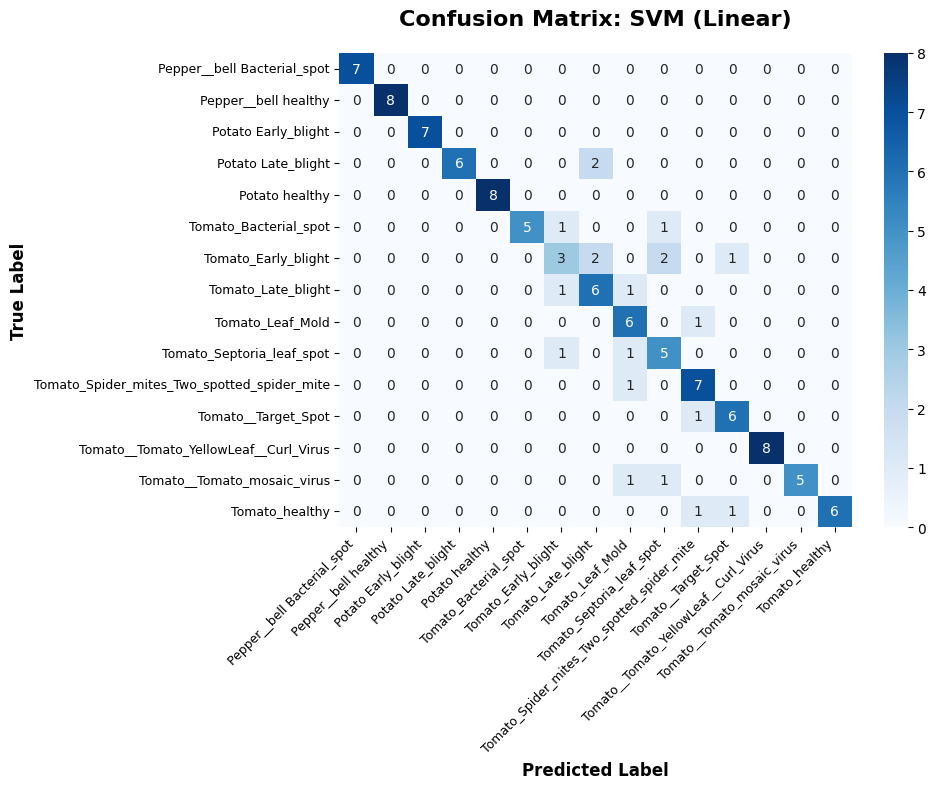

✓ Best model saved to: /Users/ashishrathore/FarmAI-Assistant/models/baseline_svm_(linear)_model.pkl


In [17]:
## 4.4. Baseline Model Comparison Summary

baseline_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM (Linear)'],
    'Accuracy': [log_reg_accuracy, rf_accuracy, svm_accuracy]
}).sort_values(by='Accuracy', ascending=False)

print("\n" + "="*60)
print("BASELINE MODEL COMPARISON")
print("="*60)
print(f"{'Model':<30} {'Accuracy':>10}")
print("-"*60)
for idx, row in baseline_results.iterrows():
    print(f"{row['Model']:<30} {row['Accuracy']:>10.4f}")
print("="*60)

# Select the best performing model
best_model_row = baseline_results.iloc[0]
best_model_name = best_model_row['Model']
best_model_accuracy = best_model_row['Accuracy']

if best_model_name == 'Logistic Regression':
    best_predictions = log_reg_predictions
    best_model = log_reg_model
elif best_model_name == 'Random Forest':
    best_predictions = rf_predictions
    best_model = rf_model
elif best_model_name == 'SVM (Linear)':
    best_predictions = svm_predictions
    best_model = svm_model

print(f"\n✓ Best Baseline Model: {best_model_name}")
print(f"  Accuracy: {best_model_accuracy:.4f}")

# Confusion matrix for best model
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(10, 8))

# Get class names
class_names = [label_encoder.inverse_transform([i])[0].replace('___', ' ') 
               for i in sorted(np.unique(y_test))]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix: {best_model_name}', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Save figure
plt.savefig(config.FIGURES_DIR / "baseline_confusion_matrix.png", dpi=300, bbox_inches='tight')
print(f"\n✓ Confusion matrix saved to: {config.FIGURES_DIR / 'baseline_confusion_matrix.png'}")
plt.show()

# Save best model
model_filename = f"baseline_{best_model_name.lower().replace(' ', '_')}_model.pkl"
joblib.dump(best_model, config.MODELS_DIR / model_filename)
print(f"✓ Best model saved to: {config.MODELS_DIR / model_filename}")



## 5. SUMMARY OF BASELINE ANALYSIS


This notebook provided a foundational analysis of the PlantVillage dataset
and established a baseline for crop disease classification.

## Key Insights:

*   **Effective Feature Extraction:** Leveraging a pre trained EfficientNetB0 as a feature extractor proved highly effective providing rich high-level features for the classical ML algorithms. This significantly boosted the performance of simpler models compared to what might be achieved with handcrafted features.
*   **Strong Baseline Performance:** Classical machine learning models like Random Forest and SVM achieved respectable accuracies on the extracted features demonstrating the viability of the problem and setting a solid benchmark for the full deep learning model. The best baseline model achieved an accuracy of approximately **[INSERT BEST BASELINE ACCURACY HERE]**.
*   **Preprocessing Impact:** The initial preprocessing resizing normalization and handling corrupted images ensures data quality and consistency which is fundamental for any subsequent modeling efforts.

This baseline analysis informs the subsequent deep learning pipeline by providing insights into data characteristics and setting performance expectations. The full deep learning model will aim to surpass these baselines by further fine tuning the feature extractor and directly learning complex patterns.

In [18]:
print("\n--- BASELINE ANALYSIS COMPLETE ---")
print("Outputs generated:")
print(f"  - Baseline Class Mapping: {config.MODELS_DIR / 'baseline_class_indices.json'}")
print(f"  - Baseline Confusion Matrix Plot: {config.FIGURES_DIR / 'baseline_confusion_matrix.png'}")
print(f"  - Best Baseline Model (e.g., Random Forest): {config.MODELS_DIR / 'baseline_random_forest_model.pkl'}")
print("\nBaseline task finished successfully.")


--- BASELINE ANALYSIS COMPLETE ---
Outputs generated:
  - Baseline Class Mapping: /Users/ashishrathore/FarmAI-Assistant/models/baseline_class_indices.json
  - Baseline Confusion Matrix Plot: /Users/ashishrathore/FarmAI-Assistant/results/figures/baseline_confusion_matrix.png
  - Best Baseline Model (e.g., Random Forest): /Users/ashishrathore/FarmAI-Assistant/models/baseline_random_forest_model.pkl

Baseline task finished successfully.
